In [987]:
import autograd.numpy as np
from autograd import grad
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt


In [1200]:
df = pd.read_csv("./train",header=None, names= ["id","c1","c2","c3"])

In [1213]:
test = pd.read_csv("./test",header=None, names= ["id","c1","c2","c3"])

In [1214]:
def getProblem(id):
    problemChunk = df[df["id"]== ("P" + str(id))][["c1", "c2", "c3"]]
    return (problemChunk[0:len(problemChunk)-1].values.astype(float), problemChunk["c3"].values[3])
  
def getTestProblem(id):
    problemChunk = test[test["id"]== ("P" + str(id))][["c1", "c2", "c3"]]
    return (problemChunk[0:len(problemChunk)-1].values.astype(float), problemChunk["c3"].values[3])
    

In [1202]:
count = 0

In [1203]:
for i in range(0,100):
    ans = getProblem(i)
    count = count + ans[1]

In [1204]:
count

89

In [1205]:
def sigmoid(x):
    return 0.5 * (np.tanh(x / 2.) + 1)

def logistic_predictions(weights, inputs):
    # Outputs probability of a label being true according to logistic model.
    return sigmoid(np.dot(inputs, weights))


In [1206]:
def reason(formulae, weights):
    W = weights[0:3,:]
    A = weights[3:6,:]
    C = weights[6:9,:]
    for d in range(0, 5):
        f1 = np.matmul(formulae, W)
        formulae = np.add(formulae, np.dot(A, f1))
        f2 = np.matmul(formulae, W)
        formulae = np.add(formulae, np.dot(A, f2))
        c = sigmoid(np.add(f2, np.dot(f1, C)))
        formulae = np.add(formulae, np.dot(A, c))
    return sigmoid(np.log(np.linalg.norm(formulae)))
    
    

In [1217]:
W = np.random.randn(3,3)
A = np.random.randn(3,3)
C = np.random.randn(3,3)

In [1218]:
weights = np.vstack([W, A, C])

In [1219]:
def training_loss(weights):
    sumT = 0
    # Training loss is the negative log-likelihood of the training labels.
    for i in range(0, 100):
        problem = getProblem(i)
        target = problem[1]
        formulae = problem[0]
        pred = reason(formulae, weights)

        sumT = sumT  - np.log(pred * target + (1 - pred) * (1 - target))
        
    return sumT/100


In [1220]:
def perf(weights):
    sumT = 0
    # Training loss is the negative log-likelihood of the training labels.
    for i in range(0, 100):
        problem = getTestProblem(i)
        target = problem[1]
        formulae = problem[0]
        pred = reason(formulae, weights)

        sumT = sumT  - np.log(pred * target + (1 - pred) * (1 - target))
        
    return sumT/100

In [1221]:
reason(getProblem(0)[0], weights)

0.99992261578811514

In [1222]:
training_gradient_fun = grad(training_loss)

In [1223]:
print("Initial loss:", training_loss(weights))

Initial loss: 1.01627755469


In [1224]:
perf(weights)

0.47046256414718129

In [1225]:
training_gradient_fun(weights)

array([[ -1.68124683e-01,   3.00228747e-02,  -9.14078600e-02],
       [  3.76257458e-02,   1.13575338e-02,   3.67937803e-03],
       [  1.06118773e-01,   9.20328829e-02,  -1.90755224e-01],
       [ -6.16452384e-02,   2.33737837e-01,  -1.92900295e-01],
       [  8.12235809e-02,  -2.61580728e-01,   2.28339391e-01],
       [ -1.17318045e-01,   4.46003194e-01,  -3.61876916e-01],
       [ -6.11923072e-05,   4.30606245e-05,  -4.53574610e-04],
       [  3.43851801e-04,  -4.35334736e-04,   1.33489367e-04],
       [  1.13037771e-03,  -1.50312001e-03,   7.80034543e-05]])

In [1226]:
for i in range(40):
    weights -= training_gradient_fun(weights) * 0.25* (1 - i/100)

In [1227]:
print("Trained loss:", training_loss(weights))

Trained loss: 0.328525069104


In [1229]:
perf(weights)

0.23209628407042371

In [968]:
answers = np.zeros(100)

In [972]:
preds = np.array([reason(getProblem(x)[0], weights) for x in range(0, 100)])

In [973]:
min(preds)

0.51795262011858645

In [974]:
max(preds)

0.94464144421026042

In [985]:
preds[preds<preds.mean()-1*preds.std()].size

23

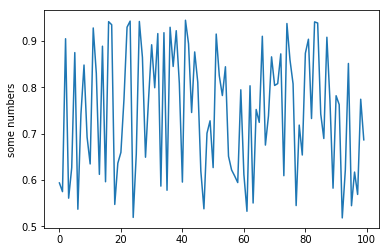

In [977]:
plt.plot(preds)
plt.ylabel('some numbers')
plt.show()


In [986]:
cogetProblem(0)

(array([[ 0.,  0., -1.],
        [-1.,  0.,  1.],
        [-1., -1.,  0.]]), 0)

In [ ]:
correct= 0
for i in range(0,100):
    problem = getProblem(i)
    formulae = problem[0]
    target = problem[1]
    pred = reason(formula, weights)
    if(target>0 and pred):
        